# Design variables

Design variables are the principal element within an optimization problem. During the optimization, the design variables are changed while influencing the objective function.

These variables can be either continuous or discrete depending on the type of optimization problem that is being studied. The turbine positions are the most common continuous design variable used in wind farm layout optimization. In essence, they are continuous because they can take an infinite amount of values for a given range. Discrete variables, on the other hand, can only take finite amount of values for a specific interval. A common discrete variable used in wind farm optimization is turbine type. The type of design variable will influence the decision of the optimization driver to use.

Continuous design variables can be treated with both gradient-free and gradient-based algorithms, where the calculation of the derivatives (in gradient-based cases) can be performed. On the other hand, discrete variables are usually analyzed with gradient-free methods, as the calculation of the gradients of these variables is not possible to perform. In some cases, it is possible to convert the discrete variable into a continuous one and then find its derivative.

Besides the turbine positions, the development of TOPFARM has allowed the inclusion of several other design variables such as:

- Turbine types,
- Turbine hub heights,
- Yaw angles,
- and even the inter-turbine spacing and rotation of a wind farm seen as a grid.

This example goes through two of the most common design variables available in TOPFARM and describes how to set them up within the `TopFarmProblem` object in the optimization.

Before working on the notebook exercises, make sure that you import or install topfarm on your newly created environment.
Ensure you are using Python 3.8 or 3.9 for compatibility with pyDOE2 and OpenMDAO.

In [1]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

In [2]:
import subprocess
import sys

# check if a package is installed
def check_and_install(package):
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of packages to check and install
packages = ["openmdao[doe]", "pyDOE2"]

for pkg in packages:
    check_and_install(pkg)

openmdao[doe] is not installed. Installing...
pyDOE2 is already installed.


**First we import some supporting Python libraries**

In [3]:
import numpy as np
import matplotlib.pyplot as plt

**We start by importing the turbine and site to use as well as the wake model from PyWake.**

**From TOPFARM we import**:

- **TopFarmProblem**. Overall topfarm problem class to which the objectives, design variables, and constraints are added
- **EasyScipyOptimizeDriver**. A subclass of ScipyOptimizeDriver which is configured for the given workflow
- **get_iea37_initial, get_iea37_constraints, get_iea37_cost**. Functions to get the initial layout, the constraints and the cost function for the IEA task 37 benchmark example
- **NoPlot, XYPlotComp**. Plotting components to visualize the results

In [4]:
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian     #wake model
from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site         #wind turbines and site used
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent   #cost model

from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.examples.iea37 import get_iea37_initial, get_iea37_constraints, get_iea37_cost
from topfarm.plotting import NoPlot, XYPlotComp

## 1) Turbine position (x,y) layout optimization

First we set up the parameters for the wind farm model simulation, that is the site and wind turbine objects as well as the wind directions to study.

In [5]:
n_wt = 9
n_wd = 16

site = IEA37Site(9)
wind_turbines = IEA37_WindTurbines()
wd = np.linspace(0.,360.,n_wd, endpoint=False)
wfmodel = IEA37SimpleBastankhahGaussian(site, wind_turbines)   #PyWake's wind farm model

c:\Users\faepi\AppData\Local\anaconda3\envs\topfarm_old\lib\site-packages\py_wake\deficit_models\gaussian.py:277: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


Now we set up the `CostModelComponent` that will calculate the AEP as the objective function of the optimization.

In [6]:
cost_comp = PyWakeAEPCostModelComponent(wfmodel, n_wt, wd=wd)

Then we can set up the optimization problem, where the initial conditions of the optimization, design variables and constraints are specified.

In [7]:
initial = get_iea37_initial(n_wt)
driver = EasyScipyOptimizeDriver()

When using the turbine positions as design variables, you can specify them in TOPFARM in 4 different ways:

    - {'x': [1, 2, 3], 'y':([3, 2, 1], 0, 1), 'z':([4, 5, 6],[4, 5, 4], [6, 7, 6])}
    - [('x', [1,2,3]), ('y',([3,2,1], 0, 1)), ('z',([4, 5, 6],[4, 5, 4], [6, 7, 6]))]
    - [('x', ([1,2,3], 0, 3, 'm')), ('y', ([3,2,1], 'm')), ('z', ([4,5,6], [4,5,4], [6,7,6]))]
    - zip('xy', pos.T)

The values are either:

- the initial value or
- on of the following tuples:
  - initial value, unit
  - initial value, lower bound, upper bound
  - initial value, lower bound, upper bound, unit

In [8]:
design_vars = dict(zip('xy', (initial[:, :2]).T))

tf_problem = TopFarmProblem(
            design_vars,
            cost_comp,
            constraints=get_iea37_constraints(n_wt),
            driver=driver,
            plot_comp=XYPlotComp())

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


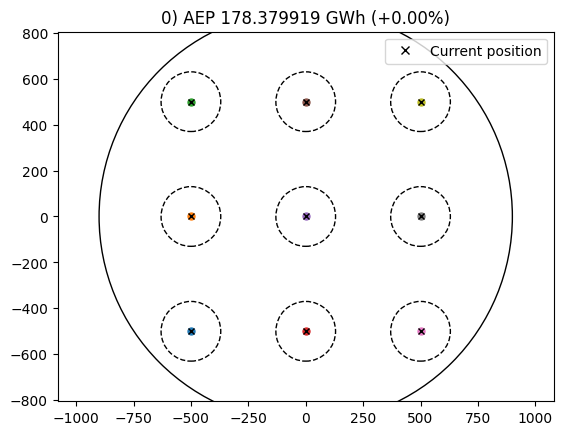

Optimization terminated successfully    (Exit mode 0)
            Current function value: -239.6945378502498
            Iterations: 171
            Function evaluations: 173
            Gradient evaluations: 171
Optimization Complete
-----------------------------------


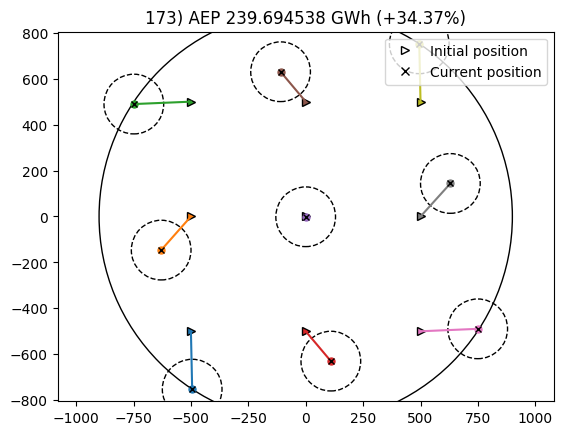

In [9]:
_, state, _ = tf_problem.optimize()

## 2) Turbine type optimization

In this example we use the turbine types as design variables, which represent discrete points in the optimization. Because of this, gradient-based methods are not suitable and gradient-free options are needed instead. For this case, we use the **FullFactorialGenerator** as our driver (see the [Drivers](#drivers.ipnyb) tutorial for more information.) We also use the `TurbineTypePlotComponent` available in TOPFARM to visualize the final turbine types.

In [10]:
from topfarm.cost_models.dummy import DummyCost
from topfarm._topfarm import TopFarmProblem
from openmdao.drivers.doe_generators import FullFactorialGenerator
from topfarm.plotting import TurbineTypePlotComponent, NoPlot

In [11]:
# define the conditions for the wind farm
positions = np.array([[0, 0], [6, 6]])  # initial turbine position
optimal_types = np.array([[2], [6]])    # optimal layout

#set up plotting component for turbine types
plot_comp = TurbineTypePlotComponent(
                turbine_type_names=["Turbine %d" % i for i in range(5)],
                plot_initial=False,
                delay=0.1, legendloc=0)

In [12]:
tf = TopFarmProblem(
            design_vars={'type': ([0, 0], 0, 4)},
            cost_comp=DummyCost(optimal_types, ['type']),
            plot_comp=plot_comp,
            driver=FullFactorialGenerator(5),
            ext_vars={'x': positions[:, 0], 'y': positions[:, 1]},
        )

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


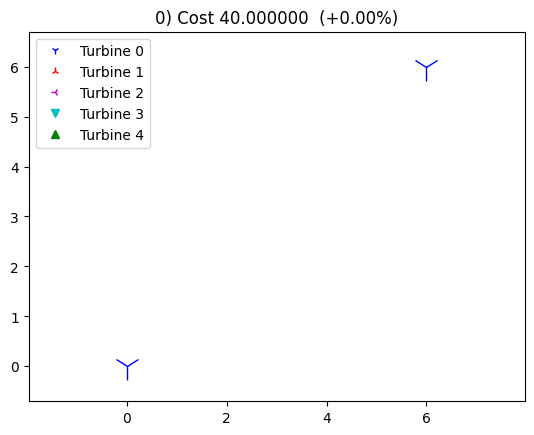

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


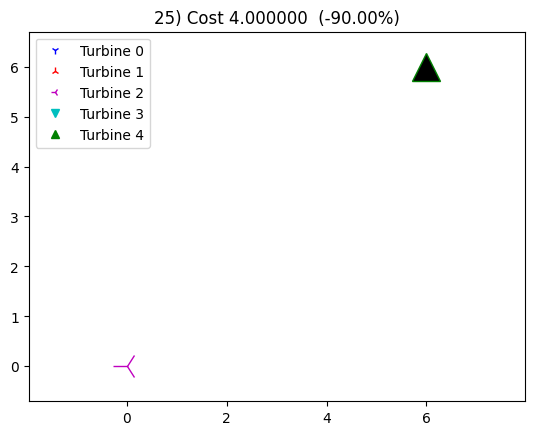

In [13]:
state = {}
cost, state, recorder = tf.optimize(state)

In [14]:
print(state['type'])

[2. 4.]
